In [6]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt

In [11]:
cap = cv2.VideoCapture(0)

# capture one frame and conver to gray scale
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# release the capture handle
cap.release()

In [31]:
def reset_gray(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

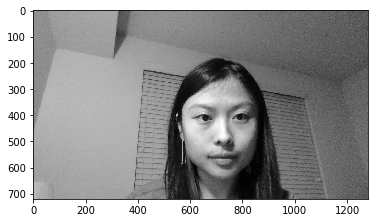

In [12]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [13]:
gray.shape

(720, 1280)

In [14]:
# front face detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/support/shape_predictor_68_face_landmarks.dat")
faces = detector(gray)

In [15]:
len(faces)

1

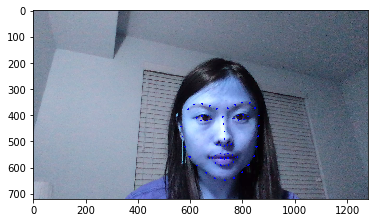

In [35]:
for f in faces:
    shape = predictor(gray, f)
    for i in range(1,68): #There are 68 landmark points on each face
        cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
    plt.imshow(frame)

In [17]:
# extract the coordinates of landmarks
face1 = faces[0]

In [18]:
shape = predictor(gray, face1)
landmarks = np.asarray([(shape.part(i).x, shape.part(i).y) for i in range(68)])

In [19]:
# validate face landmark calculations
from collections import OrderedDict

In [20]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

In [21]:
# get left and right eye coordinates
(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
leftEyePts = landmarks[lStart:lEnd]
rightEyePts = landmarks[rStart:rEnd]
(leftEyePts, rightEyePts)

(array([[767, 414],
        [782, 401],
        [802, 398],
        [819, 406],
        [805, 416],
        [785, 418]]),
 array([[629, 410],
        [646, 403],
        [667, 402],
        [682, 416],
        [665, 421],
        [644, 420]]))

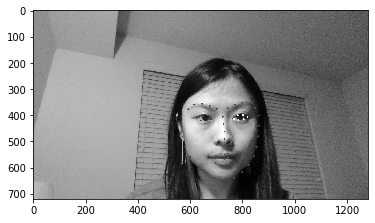

In [74]:
gray = reset_gray(frame)
for (x,y) in leftEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

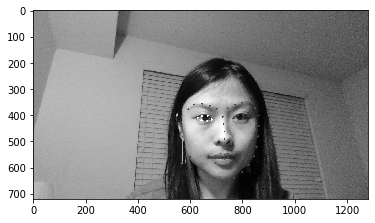

In [75]:
gray = reset_gray(frame)
for (x,y) in rightEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [37]:
# compute the center of mass for each eye
leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
(leftEyeCenter, rightEyeCenter)

(array([793, 408]), array([655, 412]))

In [38]:
# calculate the rotation angle
dY = rightEyeCenter[1] - leftEyeCenter[1]
dX = rightEyeCenter[0] - leftEyeCenter[0]
angle = np.degrees(np.arctan2(dY, dX)) - 180
(dY, dX, angle)

(4, -138, -1.66028236898282)

In [40]:
dist1 = np.sqrt((dX ** 2) + (dY ** 2))
dist2 = np.linalg.norm(leftEyeCenter - rightEyeCenter)
dist1 == dist2

True

In [68]:
# calculate scale
desiredFaceWidth=256
desiredFaceHeight=256
desiredLeftEye=(0.35, 0.35)
dist = np.linalg.norm(leftEyeCenter - rightEyeCenter)
desiredDist = 1.0 - 2 * desiredLeftEye[0]
desiredDist *= desiredFaceWidth
scale = desiredDist / dist
scale

0.556288102789689

In [69]:
eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2, (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
eyesCenter

(724, 410)

In [70]:
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
M

array([[ 5.56054565e-01, -1.61175236e-02,  3.28024680e+02],
       [ 1.61175236e-02,  5.56054565e-01,  1.70348541e+02]])

In [71]:
# update the translation component of the matrix
# TODO: figure this out
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])
M

array([[ 5.56054565e-01, -1.61175236e-02, -2.67975320e+02],
       [ 1.61175236e-02,  5.56054565e-01, -1.50051459e+02]])

In [72]:
# apply the affine transformation
gray = reset_gray(frame)
(w, h) = (desiredFaceWidth, desiredFaceHeight)
output = cv2.warpAffine(gray, M, (w, h),flags=cv2.INTER_CUBIC)
output.shape

(256, 256)

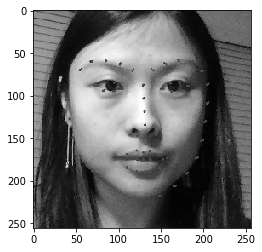

In [73]:
plt.imshow(output,cmap='gray', vmin=0, vmax=255)
plt.show()